In [33]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.colors import LogNorm
# from eval import load_model, get_prediction_and_ground_truths, eval_zeolite_aggregated, eval_zeolite_osda, eval_single_system, get_metric_dataframes
# from data.metrics import maximum_mean_discrepancy, wasserstein_distance

Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


In [34]:
def rmsd_matrix(A, B, squared=False, axis = 0):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.

    See also
    --------
    A more generalized version of the distance matrix is available from
    scipy (https://www.scipy.org) using scipy.spatial.distance_matrix,
    which also gives a choice for p-norm.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    if axis == 0:
        D_squared =  1/M*(A_dots + B_dots -2*A.dot(B.T))
    elif axis == 1:
        D_squared =  1/N*(A_dots + B_dots -2*A.dot(B.T))

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def smoothsegment(seg, Nsmooth=100):
    '''
    Helper function for plotting circular dendrogram
    '''

    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])

In [35]:
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
df_zeos = pd.read_csv('data/zeolite_descriptors_for_dendro.csv').drop(columns=['Unnamed: 0'])

In [36]:
data = dataset.get_datapoints_by_index(range(len(dataset)), scaled=False, return_dataframe=True)
x_syn_ratio, zeo_code, osda_smiles = data[1], data[3], data[13]
x_syn_ratio['zeo'], x_syn_ratio['osda'] = zeo_code, osda_smiles
x_syn_ratio

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,cryst_temp,cryst_time,zeo,osda
0,400.0,0.000000,99.0,250.0,0.0,0.05,0.250000,0.0,31.000006,0.200000,150.000000,504.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
1,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,7.500000,0.500000,175.000000,168.000000,AFI,C[N+]12CCCC[C@@H]1[C@H]1C[C@@H](C2)[C@@H]2CCCC...
2,400.0,0.000000,99.0,250.0,0.0,0.12,0.270000,0.0,44.000000,0.150000,150.000000,144.000000,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
3,400.0,0.000000,99.0,250.0,0.0,0.00,0.000000,0.5,20.000000,0.000000,115.720856,660.165100,AFI,C[N+](C)(C)C12CC3CC(CC(C3)C1)C2
4,2.5,1.717997,99.0,250.0,0.0,0.00,2.285717,0.0,28.571430,1.142857,125.000000,72.000000,BPH,CC[N+](CC)(CC)CC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23956,30.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,135.000000,558.916321,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23957,40.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,160.000000,240.032150,CHA,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23958,70.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,53.891212,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3
23959,100.0,1.717997,99.0,250.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,170.000000,193.911392,AFI,CC[N+]1(CC)CC2CC3CC(C2)CC1C3


In [37]:
# Get unique list of zeolites
unique_zeos_prefilter = list(x_syn_ratio['zeo'].value_counts().index)
unique_zeos = []
# for zeo in unique_zeos_prefilter:
#     remove = False
#     if 'Dense' in zeo:
#         remove = True
#     if '/' in zeo:
#         remove = True
#     if df_zeos['iza'].str.contains(zeo).sum() == 0:
#         print(zeo)
#         remove = True
#     if remove:
#         unique_zeos.remove(zeo)
for zeo in unique_zeos_prefilter:
    add = True
    if 'Dense' in zeo:
        add = False
    if '/' in zeo:
        add = False
    if df_zeos['iza'].str.contains(zeo).sum() == 0:
        add = False
    if add:
        unique_zeos.append(zeo)

unique_zeos = unique_zeos[:100]

In [38]:
# Featurize each zeolite with the mean and std of the synthesis ratios and synthesis conditions
zeo_feats = []
for zeo in unique_zeos:
    syn_mean = x_syn_ratio[x_syn_ratio['zeo']==zeo].drop(columns=['zeo', 'osda']).mean()
    syn_std = x_syn_ratio[x_syn_ratio['zeo']==zeo].drop(columns=['zeo', 'osda']).std().fillna(0).rename(lambda x: x+'_std')
    syn_mean_std = pd.concat([syn_mean, syn_std], axis=0)

    zeo_feats.append(syn_mean_std)
zeo_feats = pd.DataFrame(pd.concat(zeo_feats, axis=1).T, columns=syn_mean_std.index)
zeo_feats['zeo'] = unique_zeos
zeo_feats

,Si/Al,Al/P,Si/Ge,Si/B,Na/T,K/T,OH/T,F/T,H2O/T,sda1/T,...,Si/B_std,Na/T_std,K/T_std,OH/T_std,F/T_std,H2O/T_std,sda1/T_std,cryst_temp_std,cryst_time_std,zeo
0,234.812805,0.917506,95.778160,235.968262,0.148871,0.027697,0.239021,0.084773,36.352100,0.336729,...,54.985340,0.284820,0.166973,0.287174,0.260800,36.940475,0.615807,31.235201,221.771515,MFI
1,36.000309,1.090811,85.555656,213.424469,0.067966,0.051151,0.116842,0.086628,22.950012,0.575670,...,88.287636,0.187668,0.197041,0.292142,0.225935,30.382151,0.962957,36.670269,108.198372,CHA
2,200.584259,0.923173,90.259178,235.189362,0.082331,0.006954,0.223009,0.170464,16.476418,0.335711,...,56.812405,0.189851,0.044431,0.296808,0.241487,22.592487,0.322947,27.432575,192.359940,BEA
3,24.160595,0.768018,22.862745,55.568260,0.003239,0.001623,0.008409,0.041064,29.431057,0.545752,...,103.727066,0.018092,0.016120,0.048930,0.122903,42.505108,0.840680,23.122162,117.425781,AFI
4,267.393768,0.771811,96.214653,236.392517,0.099177,0.003921,0.211627,0.106432,38.856350,0.307537,...,54.075230,0.182421,0.030401,0.247215,0.200540,45.862514,0.356268,19.278879,377.763214,MTW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,167.181976,1.030798,99.000000,250.000000,0.096667,0.070667,0.292087,0.000000,10.711604,0.194591,...,0.000000,0.053381,0.049220,0.116834,0.000000,4.767484,0.080863,9.072224,106.916985,PAU
96,375.000000,0.085900,94.050003,115.280251,0.000000,0.000000,0.000000,0.100000,56.775002,0.593000,...,125.128525,0.000000,0.000000,0.000000,0.205196,41.601013,0.282472,15.849538,241.587357,SGT
97,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013889,10.416667,0.655556,...,0.000000,0.000000,0.000000,0.000000,0.058926,2.056195,0.675820,0.000000,0.000000,PON
98,111.111115,1.240775,27.500000,69.444443,0.453845,0.033333,0.725440,0.000000,37.526474,0.604822,...,115.222153,0.217522,0.102899,0.408656,0.000000,15.032896,0.496105,19.647631,456.433228,NAT


# Zeolite hierarchical clustering

In [39]:
zeo_feats_T = zeo_feats.T.drop(index='zeo')
zeo_feats_T.columns = zeo_feats['zeo']
zeo_feats_T

zeo,MFI,CHA,BEA,AFI,MTW,LTA,FAU,MOR,MWW,TON,...,IWV,AFN,ITG,SFE,NSI,PAU,SGT,PON,NAT,ITN
Si/Al,234.812805,36.000309,200.584259,24.160595,267.393768,74.143143,16.730663,46.413464,169.065811,209.152328,...,65.252716,0.0,260.278107,314.285706,125.349022,167.181976,375.0,0.0,111.111115,90.006874
Al/P,0.917506,1.090811,0.923173,0.768018,0.771811,1.020635,1.608891,1.675742,1.062638,1.107355,...,1.639906,0.353809,0.654475,0.245428,1.030798,1.030798,0.0859,1.0,1.240775,1.431664
Si/Ge,95.77816,85.555656,90.259178,22.862745,96.214653,58.972145,94.836998,98.797546,97.293106,95.064987,...,95.409088,0.0,6.844958,89.571426,84.150002,99.0,94.050003,0.0,27.5,99.0
Si/B,235.968262,213.424469,235.189362,55.56826,236.392517,180.755402,239.926743,248.48671,192.112213,239.746689,...,250.0,0.0,114.087936,36.904762,212.5,250.0,115.280251,0.0,69.444443,250.0
Na/T,0.148871,0.067966,0.082331,0.003239,0.099177,0.468066,0.82067,0.520997,0.122632,0.129105,...,0.037597,0.0,0.0,0.018324,0.025882,0.096667,0.0,0.0,0.453845,0.0
K/T,0.027697,0.051151,0.006954,0.001623,0.003921,0.00045,0.008145,0.017665,0.17536,0.07229,...,0.0,0.0,0.0,0.0,0.0,0.070667,0.0,0.0,0.033333,0.0
OH/T,0.239021,0.116842,0.223009,0.008409,0.211627,0.642206,0.810754,0.436392,0.193178,0.153517,...,0.067755,0.0,0.42377,0.045971,0.002941,0.292087,0.0,0.0,0.72544,0.0
F/T,0.084773,0.086628,0.170464,0.041064,0.106432,0.162985,0.001772,0.015825,0.115483,0.093882,...,0.051304,0.005952,0.0,0.0,0.0,0.0,0.1,0.013889,0.0,0.478121
H2O/T,36.3521,22.950012,16.476418,29.431057,38.85635,36.957428,35.125847,30.818159,29.734591,36.099159,...,9.166341,106.488098,12.458319,39.631023,39.303856,10.711604,56.775002,10.416667,37.526474,2.493594
sda1/T,0.336729,0.57567,0.335711,0.545752,0.307537,1.142661,0.124709,0.224894,0.430358,0.487803,...,0.243017,0.580357,0.242097,0.28968,0.041394,0.194591,0.593,0.655556,0.604822,0.23906


In [40]:
zeo_feats_T_scaled = (zeo_feats_T-zeo_feats_T.min())/(zeo_feats_T.max()-zeo_feats_T.min()).astype(float)
zeo_feats_T_scaled = zeo_feats_T_scaled.astype(float)

In [41]:
zeo_rmsd = pd.DataFrame(rmsd_matrix(zeo_feats_T_scaled.T.to_numpy(), zeo_feats_T_scaled.T.to_numpy()),
                        index=zeo_feats_T_scaled.columns, columns=zeo_feats_T_scaled.columns)

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


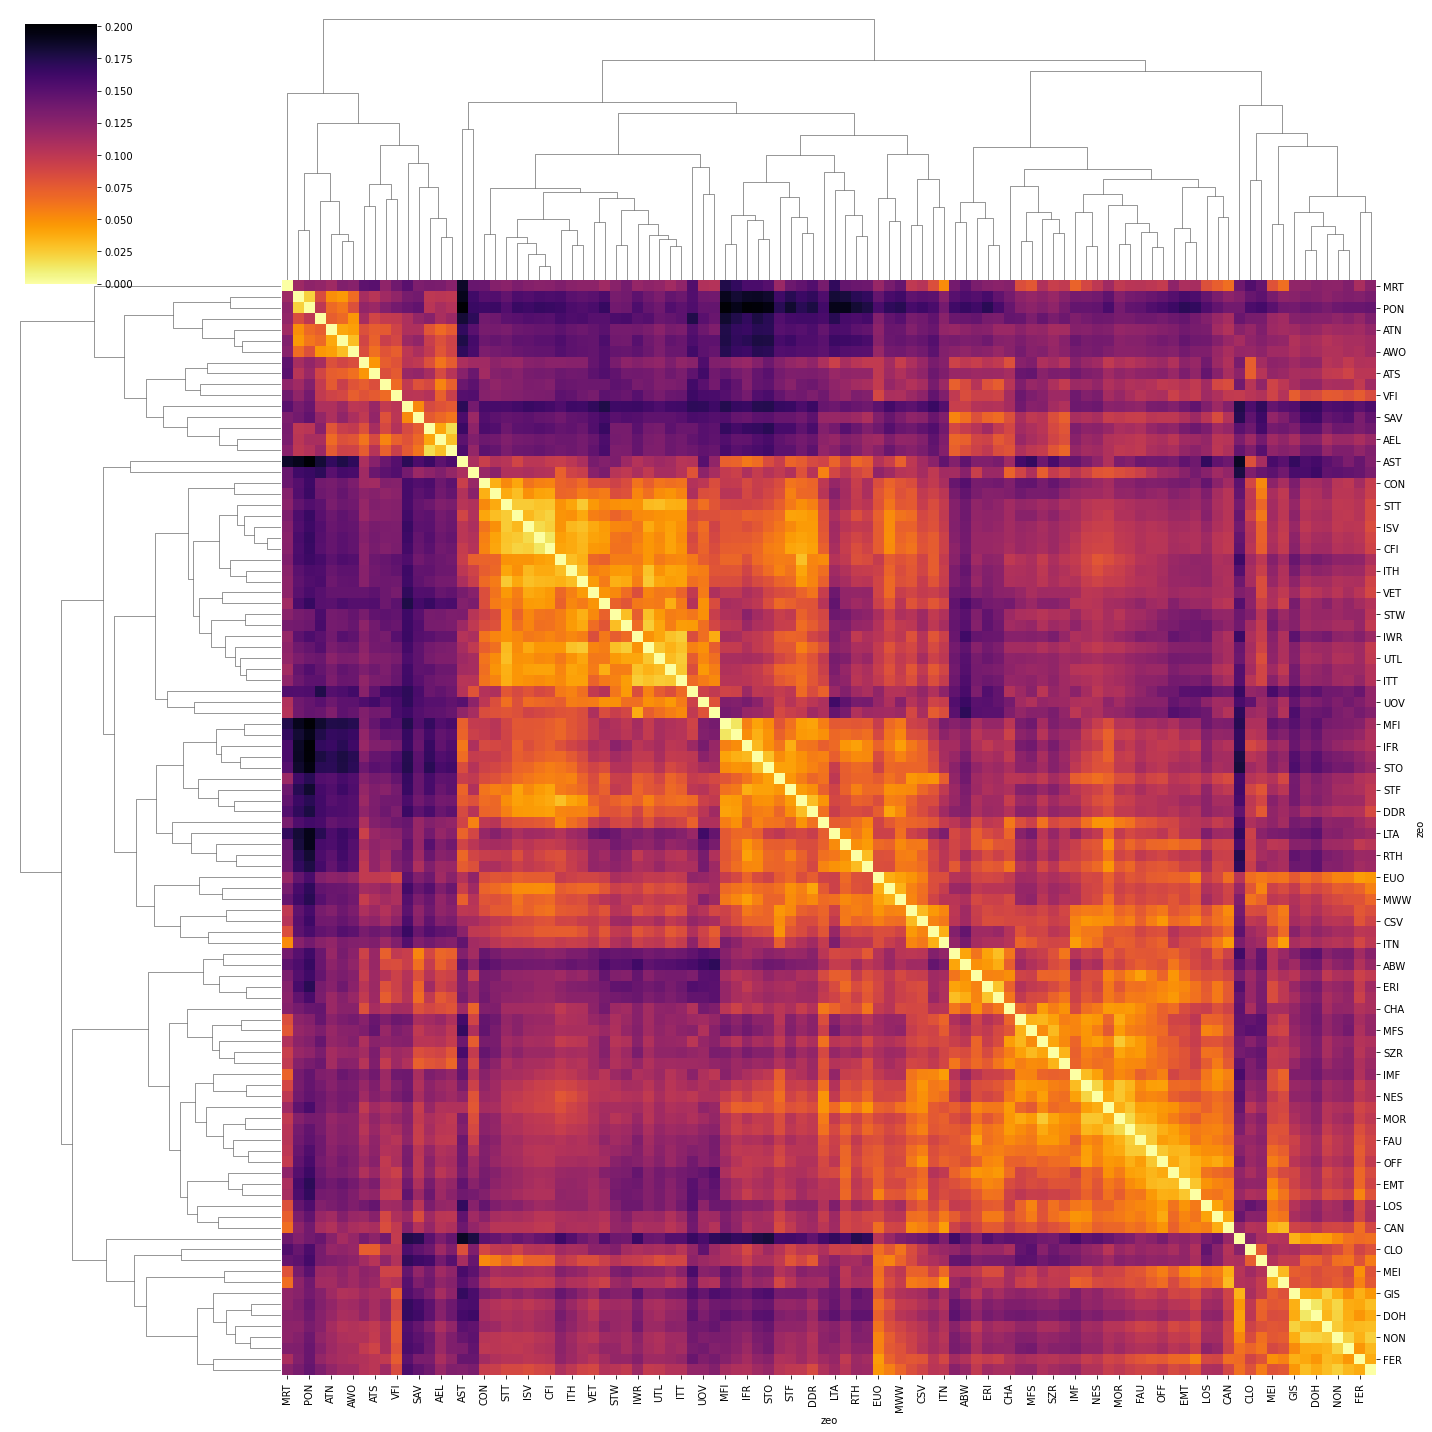

In [42]:
sns.clustermap(zeo_rmsd, cmap = "inferno_r", figsize=(20, 20))

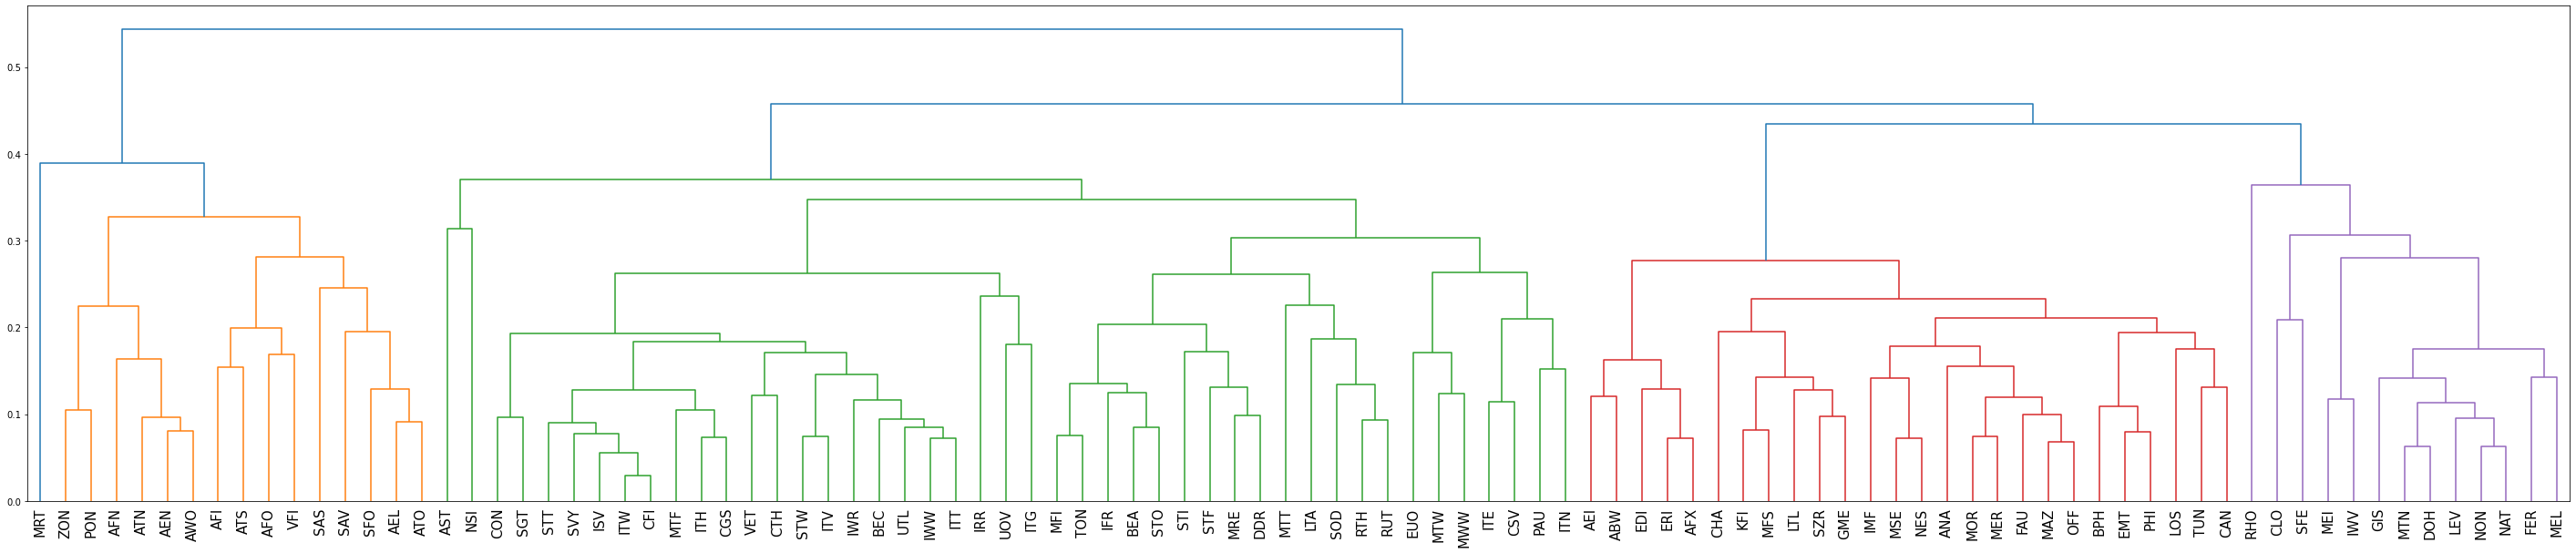

In [43]:
row_linkage = hierarchy.linkage(
    distance.pdist(zeo_rmsd.to_numpy()), method='average')

fig = plt.figure(figsize=(50, 10))
ax = fig.add_subplot(1, 1, 1)

dendro = hierarchy.dendrogram(row_linkage, labels = zeo_rmsd.columns.tolist(), ax=ax)
ax.tick_params(axis='x', which='major', labelsize=15)

plt.show()

In [69]:
def plot_dendrogram(icoord,dcoord,figsize, prop1, prop2=None, prop3=None, prop4=None, labels = [], polar=False, save_path=None):
    if polar:
        radius = 20 # radius of circle
        dcoord = -dcoord*radius
#         dcoord = -np.log(dcoord+1)*radius
        gap = 0.1 # 0.1
        imax = icoord.max()
        imin = icoord.min()
        icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*np.pi

    n_prop = 0
    for p in prop1, prop2, prop3, prop4:
        if p != None:
            n_prop += 1
        
    with plt.style.context("seaborn-white"):
        fig = plt.figure(figsize=figsize, dpi=100)
        ax = fig.add_subplot(111, polar=polar)
        
        for xs, ys in zip(icoord, dcoord):
            start, end = xs[0], xs[2]
            
            # Default colors
            color = 'black'
            linewidth = 1.5
            
            # Grp A
            if (start > 0) and (end < 0.6) and (ys[1] > -12):
                color     = 'tab:red'
                linewidth = 3

            # Grp B
            if (start > 0.9) and (end < 1.3) and (ys[1] > -12):
                color     = 'tab:green'
                linewidth = 3
            
            # Grp C
            if (start > 1.25) and (end < 1.9) and (ys[1] > -12):
                color     = 'tab:orange'
                linewidth = 3

            # Grp D
            if (start > 1.85) and (end < 2.65) and (ys[1] > -12):
                color     = 'tab:blue'
                linewidth = 3
            
            if polar:
                xs = smoothsegment(xs)
                ys = smoothsegment(ys)
                
            
            ax.plot(xs,ys, color=color, 
                        linewidth=linewidth
                       )
        if polar:
            ax.spines['polar'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
#             ax.set_rlabel_position(0)
            Nxticks = len(labels)
            xticks = np.linspace(gap/2, 1-gap/2, Nxticks)
            ax.set_xticks(xticks*np.pi)

            ax.set_xticklabels(labels)
            ax.xaxis.grid(False)
            
            
            labels = []
            angles = []
            p1s = []
            p2s = []
            p3s = []
            p4s = []
            for label, angle in zip(ax.get_xticklabels(), xticks*np.pi):
                
                x,y = angle, 0
                lab = ax.text(x,y, label.get_text(), 
                              transform=label.get_transform(),
                              ha=label.get_ha(), va=label.get_va(),
                             fontsize=20,
                             )
                degrees = np.degrees(angle)
                if degrees > 90 and degrees < 270:
                    degrees = degrees + 180
                lab.set_rotation(degrees)
                labels.append(lab)

                # Zeolite property
                if prop1 in df_zeos.columns:
                    p1 = df_zeos[df_zeos['iza']==label.get_text()][prop1].item()
                else:
                    p1 = zeo_feats[zeo_feats['zeo']==label.get_text()][prop1].item()
                
                if prop2 != None:
                    if prop2 in df_zeos.columns:
                        p2 = df_zeos[df_zeos['iza']==label.get_text()][prop2].item()
                    else:
                        p2 = zeo_feats[zeo_feats['zeo']==label.get_text()][prop2].item()

                if prop3 != None:
                    if prop3 in df_zeos.columns:
                        p3 = df_zeos[df_zeos['iza']==label.get_text()][prop3].item()
                    else:
                        p3 = zeo_feats[zeo_feats['zeo']==label.get_text()][prop3].item()

                if prop4 != None:
                    if prop4 in df_zeos.columns:
                        p4 = df_zeos[df_zeos['iza']==label.get_text()][prop4].item()
                    else:
                        p4 = zeo_feats[zeo_feats['zeo']==label.get_text()][prop4].item()
                
# #                 Draw molecule
#                 smiles = label.get_text()
#                 mol = Chem.MolFromSmiles(smiles)
#                 o = Draw.MolDrawOptions()
#                 o.bondLineWidth = 5
#                 mol_img = Draw.MolToImage(mol, options=o, size=(300, 300))
#                 r = 0.41 # radius of molecule images in fractional
#                 x_cor, y_cor = -0.01, -0.02 # correction in x y fractions
#                 img_ax = fig.add_axes([0.5+r*np.cos(angle)+x_cor,0.5+r*np.sin(angle)+y_cor,0.045,0.045], anchor='C', zorder=1)
#                 img_ax.imshow(mol_img)
#                 img_ax.axis('off')
               
                angles.append(angle)
                p1s.append(p1)
                if prop2 != None:
                    p2s.append(p2)
                if prop3 != None:
                    p3s.append(p3)
                if prop4 != None:
                    p4s.append(p4)
            
            ax.set_xticklabels([])
            ax.set_ylim(top=0.66*n_prop) # distance between ends of dendrogram child nodes and xlabels
            
            
            # Define angles
            n = len(labels)
            start, end = angles[0], angles[-1]
            a = np.linspace(start, end, n) # angles
            
            # Property 1
            rad = np.linspace(0, 0.4, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
            r, th = np.meshgrid(rad, a)
            z = np.array(p1s)
            z = np.vstack(n*[z]).T

            mesh = ax.pcolormesh(th, r, z, cmap ='Oranges_r',
                                # vmax=3
                                # norm = LogNorm(),
)
            ax.plot(a, r, ls='none') 
            # cbar_pos = fig.add_axes([0.415, 0.41, 0.2, 0.01]) # x, y, width, height
            cbar_pos = fig.add_axes([0.415, 0.49-0.04*(n_prop-1), 0.2, 0.01]) # x, y, width, height
            cbar1 = fig.colorbar(mappable=mesh, cax=cbar_pos, orientation='horizontal', fraction=0.02, pad=-0.5)
            cbar1.set_label(prop1, fontsize=20)
            cbar1.ax.set_xticklabels([0, 100, 200, 300, r"$\infty$"])
            cbar1.ax.tick_params(size=5, labelsize=20)

            # Property 2
            if prop2 != None:
                rad = np.linspace(0.5, 0.4+0.5*1, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
                r, th = np.meshgrid(rad, a)
                z = np.array(p2s)
                z = np.vstack(n*[z]).T

                mesh = ax.pcolormesh(th, r, z, cmap ='Purples_r',
                                     vmax=100,
                                    # norm = LogNorm(),
                                    
    )
                ax.plot(a, r, ls='none') 
                # cbar_pos = fig.add_axes([0.415, 0.45, 0.2, 0.01]) # x, y, width, height
                cbar_pos = fig.add_axes([0.415, 0.49-0.04*(n_prop-2), 0.2, 0.01]) # x, y, width, height
                cbar2 = fig.colorbar(mappable=mesh, cax=cbar_pos, orientation='horizontal', fraction=0.02, pad=-0.6)
                cbar2.set_label(prop2, fontsize=20)
                cbar2.ax.set_xticklabels([0, 20, 40, 60, 80, r"$\infty$"])
                cbar2.ax.tick_params(size=5, labelsize=20)

            # Property 3
            if prop3 != None:
                rad = np.linspace(1.0, 0.4+0.5*2, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
                r, th = np.meshgrid(rad, a)
                z = np.array(p3s)
                z = np.vstack(n*[z]).T

                mesh = ax.pcolormesh(th, r, z, cmap ='Blues_r',
                                    # norm = LogNorm(),
    )
                ax.plot(a, r, ls='none') 
                # cbar_pos = fig.add_axes([0.415, 0.49, 0.2, 0.01]) # x, y, width, height
                cbar_pos = fig.add_axes([0.415, 0.49-0.04*(n_prop-3), 0.2, 0.01]) # x, y, width, height
                cbar3 = fig.colorbar(mappable=mesh, cax=cbar_pos, orientation='horizontal', fraction=0.02, pad=-0.6)
                cbar3.set_label(prop3, fontsize=20)
                cbar3.ax.set_xticklabels([0, 50, 100, 150, 200, r"$\infty$"])
                cbar3.ax.tick_params(size=5, labelsize=20)

            # Property 4
            if prop4 != None:
                rad = np.linspace(1.5, 0.4+0.5*3, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
                r, th = np.meshgrid(rad, a)
                z = np.array(p4s)
                z = np.vstack(n*[z]).T

                mesh = ax.pcolormesh(th, r, z, cmap ='Greens',
                                    # norm = LogNorm(),

    )
                ax.plot(a, r, ls='none') 
                # cbar_pos = fig.add_axes([0.415, 0.49, 0.2, 0.01]) # x, y, width, height
                cbar_pos = fig.add_axes([0.415, 0.49-0.04*(n_prop-4), 0.2, 0.01]) # x, y, width, height
                cbar4 = fig.colorbar(mappable=mesh, cax=cbar_pos, orientation='horizontal', fraction=0.02, pad=-0.6)
                cbar4.set_label(prop4, fontsize=20)
                # cbar4.ax.set_xticklabels([0, 50, 100, 150, 200, r"$\infty$"])
                cbar4.ax.tick_params(size=5, labelsize=20)
            
        if save_path != None:
            fig.savefig(save_path, bbox_inches='tight', transparent=True, dpi = 500)
                
    return fig, ax

labels = zeo_feats_T_scaled.columns.tolist()
cols = [labels[i] for i in dendro['leaves']]

fig, ax = plot_dendrogram(np.array(dendro['icoord']), np.array(dendro['dcoord']), (30,30), 
                labels=cols, polar=True, 
                # prop1='Na/T', prop2='K/T',
                prop1='Si/Al', 
                prop2='Si/Ge', 
                prop3='Si/B',
                prop4='cryst_time',
                # save_path='figs/dendro.pdf',
                )
fig.show()


/tmp/ipykernel_3945537/3447167852.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar1.ax.set_xticklabels([0, 100, 200, 300, r"$\infty$"])
/tmp/ipykernel_3945537/3447167852.py:177: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.ax.set_xticklabels([0, 20, 40, 60, 80, r"$\infty$"])
/tmp/ipykernel_3945537/3447167852.py:195: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar3.ax.set_xticklabels([0, 50, 100, 150, 200, r"$\infty$"])
